In [2]:
import os
import sys
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import keras
import re

#Set GPU=====
class GPUError(Exception):
    pass

def find_unused_gpu():
    x = os.popen('nvidia-smi').read()
    y = re.findall(r'[0-9]*MiB \/',x)
    for i,count in enumerate(y):
        if int(count[:-5]) == 0:
            return str(i)
    raise(GPUError)

os.environ["CUDA_VISIBLE_DEVICES"] = find_unused_gpu()
#==============

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")



# Path to Shapes trained weights
#SHAPES_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_shapes.h5")

In [3]:
import nucleus
config = nucleus.NucleusConfig()
#config.BACKBONE='mobilenet224v1'
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     6
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        400
DETECTION_MIN_CONFIDENCE       0
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 6
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                2.0
IMAGE_RESIZE_MODE              crop
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'mrcnn_class_loss': 1.0, 'mrcnn_mask_loss': 1.0, 'rpn_bbox_loss': 1.0, 'rpn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES   

In [4]:
res50_tr_time = '20180925T1332'
mobile_tr_time = '20180925T1034'
res50_best_ep = 39
mobile_best_ep = 37

if config.BACKBONE == 'resnet50':
    train_time = res50_tr_time
    epoch = res50_best_ep
elif config.BACKBONE == 'mobilenet224v1':
    train_time = mobile_tr_time
    epoch = mobile_best_ep

# Local path to trained weights file
NUCLEUS_MODEL_PATH = os.path.join(MODEL_DIR, "nucleus{}/mask_rcnn_nucleus_{}.h5".
                                  format(train_time,str(epoch).zfill(4))
                                 )

In [5]:
print(NUCLEUS_MODEL_PATH)

/medical_data/zhuoyao_workspace/mask-rcnn/original/Mask_RCNN/logs/nucleus20180925T1332/mask_rcnn_nucleus_0039.h5


In [6]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/device:GPU:0" 

In [7]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [8]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

# Set weights file path
weights_path = NUCLEUS_MODEL_PATH
# Or, uncomment to load the last model you trained
# weights_path = model.find_last()

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  /medical_data/zhuoyao_workspace/mask-rcnn/original/Mask_RCNN/logs/nucleus20180925T1332/mask_rcnn_nucleus_0039.h5
Re-starting from epoch 39


In [9]:
# Show stats of all trainable weights    
visualize.display_weight_stats(model)

WEIGHT NAME,SHAPE,MIN,MAX,STD
conv1/kernel:0,"(7, 7, 3, 64)",-0.6702,+0.7066,+0.1112
conv1/bias:0,"(64,)",-0.0000,+0.0000,+0.0000
bn_conv1/gamma:0,"(64,)",+0.5125,+2.6809,+0.4658
bn_conv1/beta:0,"(64,)",-2.6546,+6.3536,+1.8952
bn_conv1/moving_mean:0,"(64,)",-3.5374,+3.3343,+1.0033
bn_conv1/moving_variance:0*** Overflow?,"(64,)",+184.1078,+83614.7344,+13554.5430
res2a_branch2a/kernel:0,"(1, 1, 64, 64)",-0.7178,+0.3902,+0.0716
res2a_branch2a/bias:0,"(64,)",-0.0012,+0.0014,+0.0006
bn2a_branch2a/gamma:0,"(64,)",+0.5096,+2.0650,+0.3736
bn2a_branch2a/beta:0,"(64,)",-2.4109,+3.6058,+1.1670


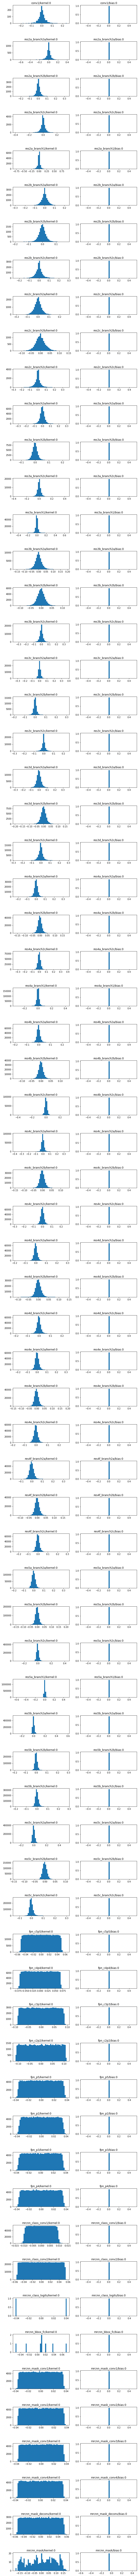

In [10]:
# Pick layer types to display
LAYER_TYPES = ['Conv2D', 'Dense', 'Conv2DTranspose']
# Get layers
layers = model.get_trainable_layers()
layers = list(filter(lambda l: l.__class__.__name__ in LAYER_TYPES, 
                layers))
# Display Histograms
fig, ax = plt.subplots(len(layers), 2, figsize=(10, 3*len(layers)),
                       gridspec_kw={"hspace":1})
for l, layer in enumerate(layers):
    weights = layer.get_weights()
    for w, weight in enumerate(weights):
        tensor = layer.weights[w]
        ax[l, w].set_title(tensor.name)
        _ = ax[l, w].hist(weight[w].flatten(), 50)
